Enable auto-reloading of external modules

In [49]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import dependencies

In [50]:
from matplotlib import rcParams
from sys import getsizeof
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

from utils.data_loader import *
from utils.null_handler import *
from utils.EDA_utils import *
from utils.simple_utils import *
from utils.model_tuning_utils import *
from config import *

import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

SEED=10
plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100

In [51]:
try:
    from folktables import ACSDataSource, ACSEmployment
except:
    !pip install folktables
    from folktables import ACSDataSource, ACSEmployment

## Loading ACSEmployment data

In [52]:
config = {
    'state': ["NY"],
    'year': '2018',
    'task': ACSEmployment
}
TARGET_COLUMN = 'MAR'
COLUMN_TYPE = get_column_type(TARGET_COLUMN)

In [53]:
X_data_load, y_data = ACSDataLoader(task=config['task'], state=config['state'], year=config['year'])

In [54]:
# If the task is ACSEmployment, we can optimize the file size
print(f'Original: {int(getsizeof(X_data_load) / 1024**2)} mb')
print(f'Optimized: {int(getsizeof(optimize_ACSEmployment(X_data_load)) / 1024**2)} mb')

X_data = optimize_ACSEmployment(X_data_load)

Original: 24 mb
Optimized: 12 mb


In [55]:
missing = ['SCHL', 'ESP', 'MIG', 'MIL', 'DREM']
X_data = initially_handle_nulls(X_data, missing)
# Rechecking if there are nulls -- if the null_handler has run correctly, there should not be
X_data.isnull().sum()

Dataset shape before handling nulls:  (196967, 16)
Impute values:  {'SCHL': 0, 'ESP': 0, 'MIG': 0, 'MIL': 0, 'DREM': 0}
Dataset shape after handling nulls:  (196967, 16)


AGEP        0
SCHL        0
MAR         0
RELP        0
DIS         0
ESP         0
CIT         0
MIG         0
MIL         0
ANC         0
NATIVITY    0
DEAR        0
DEYE        0
DREM        0
SEX         0
RAC1P       0
dtype: int64

## Tune hyper-parameters and find the best model

In [56]:
# Copy datasets for tuning to avoid confusion with datasets for imputations
baseline_X_data, baseline_y_data = X_data.copy(deep=True), y_data.copy(deep=True)

baseline_X_train_, baseline_X_test, baseline_y_train_, baseline_y_test = train_test_split(baseline_X_data, baseline_y_data, test_size=0.2, random_state=SEED)
baseline_X_train, baseline_X_val, baseline_y_train, baseline_y_val = train_test_split(baseline_X_train_, baseline_y_train_, test_size=0.25, random_state=SEED)
print("baseline_X_train shape: ", baseline_X_train.shape)
print("baseline_X_val shape: ", baseline_X_val.shape)
print("baseline_X_test shape: ", baseline_X_test.shape)

baseline_X_train shape:  (118179, 16)
baseline_X_val shape:  (39394, 16)
baseline_X_test shape:  (39394, 16)


In [57]:
scaler = StandardScaler()
baseline_X_train = scaler.fit_transform(baseline_X_train)
baseline_X_val = scaler.transform(baseline_X_val)
baseline_X_test = scaler.transform(baseline_X_test)

In [58]:
n_folds = 3
samples_per_fold = len(baseline_y_val)
best_results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                        'Accuracy_Score',
                                        'Model_Best_Params', 'Model_Pred'))

In [59]:
config_models = [
    {
        'model_name': 'LogisticRegression',
        'model': LogisticRegression(random_state=SEED),
        'params': {
            'penalty': ['none', 'l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'max_iter': range(50, 251, 50),
        }
    },
    {
        'model_name': 'DecisionTreeClassifier',
        'model': DecisionTreeClassifier(random_state=SEED),
        'params': {
            "max_depth": [2, 3, 4, 6, 10],
            "max_features": [0.6, 'sqrt'],
            "criterion": ["gini", "entropy"]
        }
    },
    {
        'model_name': 'XGBClassifier',
        'model': XGBClassifier(random_state=SEED, verbosity = 0),
        'params': {
            'learning_rate': [0.1, 0.01],
            'n_estimators': [100, 200],
            'max_depth': range(3, 10, 2),
            'objective':  ['binary:logistic'],
        }
    }
]

Tuning for LogisticRegression is finished
####################  Folktables [NY 2018]  ####################
Test model:  LogisticRegression
Test model parameters:
{'max_iter': 50, 'penalty': 'none', 'solver': 'newton-cg'}

              precision    recall  f1-score   support

           0      0.832     0.722     0.773     21095
           1      0.722     0.832     0.773     18299

    accuracy                          0.773     39394
   macro avg      0.777     0.777     0.773     39394
weighted avg      0.781     0.773     0.773     39394



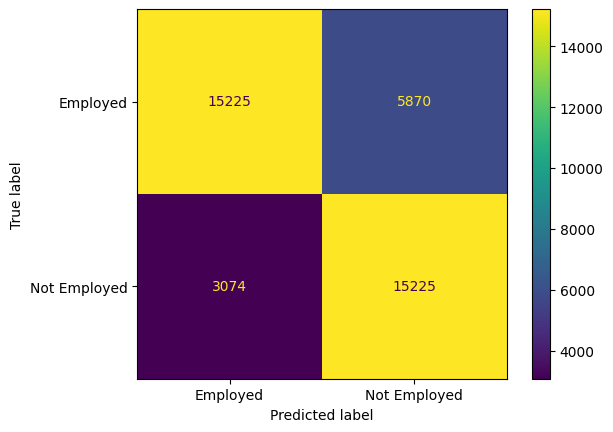

Tuning for DecisionTreeClassifier is finished
####################  Folktables [NY 2018]  ####################
Test model:  DecisionTreeClassifier
Test model parameters:
{'criterion': 'gini', 'max_depth': 2, 'max_features': 0.6}

              precision    recall  f1-score   support

           0      0.664     0.800     0.726     21095
           1      0.698     0.533     0.604     18299

    accuracy                          0.676     39394
   macro avg      0.681     0.666     0.665     39394
weighted avg      0.680     0.676     0.669     39394



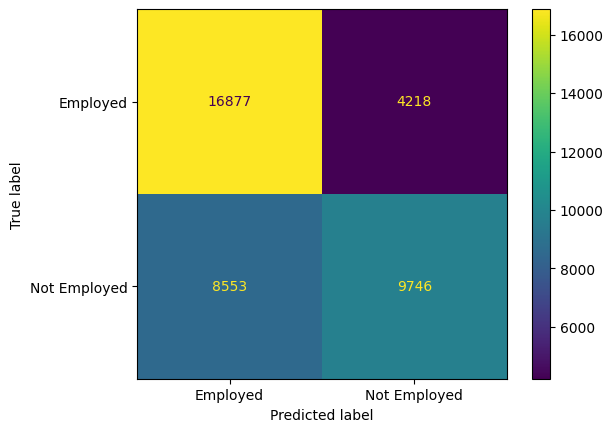

Tuning for XGBClassifier is finished
####################  Folktables [NY 2018]  ####################
Test model:  XGBClassifier
Test model parameters:
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'objective': 'binary:logistic'}

              precision    recall  f1-score   support

           0      0.867     0.803     0.834     21095
           1      0.790     0.858     0.823     18299

    accuracy                          0.828     39394
   macro avg      0.829     0.830     0.828     39394
weighted avg      0.831     0.828     0.829     39394



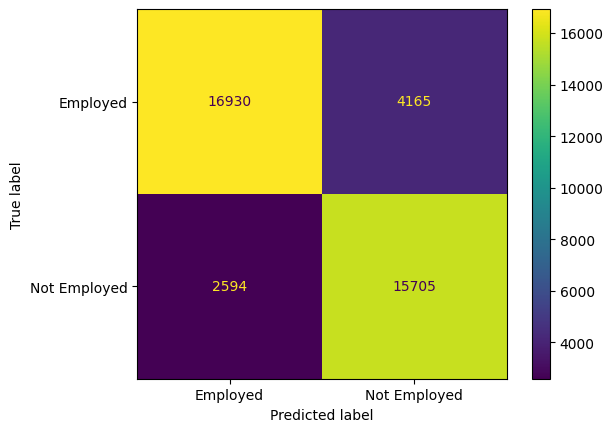

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,Folktables [NY 2018],LogisticRegression,0.772960,0.772960,"{'max_iter': 50, 'penalty': 'none', 'solver': ..."
1,Folktables [NY 2018],DecisionTreeClassifier,0.664831,0.675814,"{'criterion': 'gini', 'max_depth': 2, 'max_fea..."
2,Folktables [NY 2018],XGBClassifier,0.828260,0.828426,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


In [60]:
ML_results_df = test_ML_models(best_results_df, config_models, n_folds, samples_per_fold,
                               baseline_X_train, baseline_y_train, baseline_X_test, baseline_y_test, "Folktables [NY 2018]",
                               show_plots=True, debug_mode=True)
ML_results_df

In [61]:
for index, row in ML_results_df.iterrows():
    print(f'\n\nModel name: {row["Model_Name"]}')
    pprint(row['Model_Best_Params'])



Model name: LogisticRegression
{'max_iter': 50, 'penalty': 'none', 'solver': 'newton-cg'}


Model name: DecisionTreeClassifier
{'criterion': 'gini', 'max_depth': 2, 'max_features': 0.6}


Model name: XGBClassifier
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'objective': 'binary:logistic'}


## Simulate Null Scenarios

In [62]:
corrupted_data = simulate_scenario(X_data, simulated_scenarios_dict[TARGET_COLUMN])

## Impute Nulls

In [ ]:
# Set style for seaborn plots
sns.set_style("darkgrid")

Check correctness of conditional techniques

In [63]:
mapping_dict = check_conditional_techniques(corrupted_data, TARGET_COLUMN)
pprint(mapping_dict)

{'RAC1P': {'RAC1P-1': (60781, 'MAR-1.0'),
           'RAC1P-2': (13861, 'MAR-5.0'),
           'RAC1P-3': (271, 'MAR-5.0'),
           'RAC1P-4': (3, 'MAR-1.0'),
           'RAC1P-5': (143, 'MAR-5.0'),
           'RAC1P-6': (8429, 'MAR-1.0'),
           'RAC1P-7': (42, 'MAR-5.0'),
           'RAC1P-8': (6255, 'MAR-5.0'),
           'RAC1P-9': (3749, 'MAR-5.0')},
 'SEX': {'SEX-1': (45357, 'MAR-5.0'), 'SEX-2': (42692, 'MAR-5.0')}}


Print plots for analysis





 ###############  Impute MAR column with drop-column technique  ###############




 ###############  Impute MAR column with drop-rows technique  ###############
Number of nulls in MAR column in the corrupted dataframe:  8603
Number of nulls in MAR column in the imputed dataframe:  0


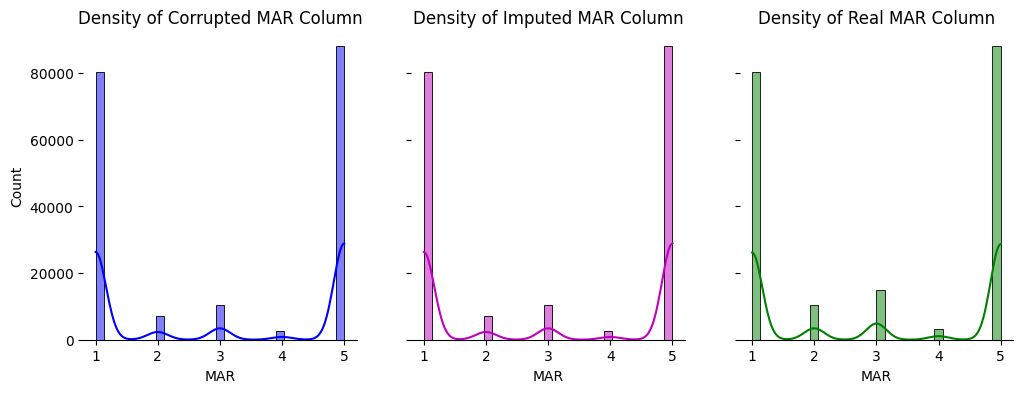





 ###############  Impute MAR column with predict-by-sklearn technique  ###############
Number of nulls in MAR column in the corrupted dataframe:  8603
Number of nulls in MAR column in the imputed dataframe:  0


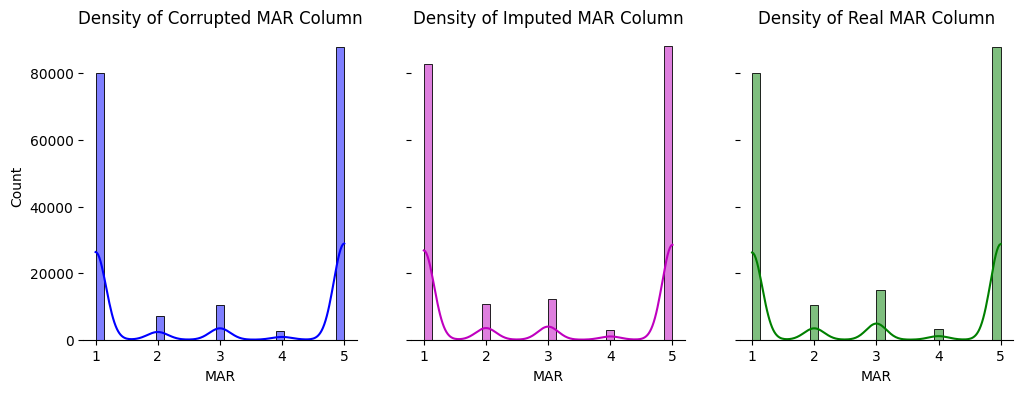





 ###############  Impute MAR column with impute-by-mode technique  ###############
Impute values:  {'MAR': 5.0}
Number of nulls in MAR column in the corrupted dataframe:  8603
Number of nulls in MAR column in the imputed dataframe:  0


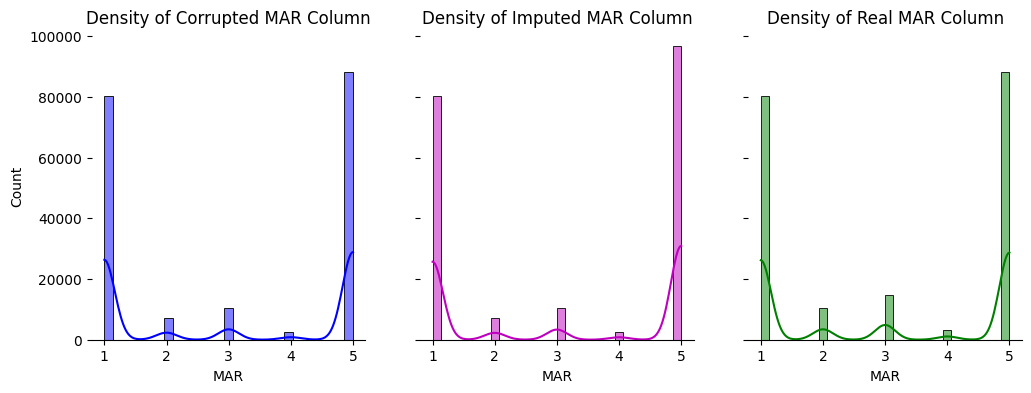





 ###############  Impute MAR column with impute-by-mode-trimmed technique  ###############
Impute values:  {'MAR': 5.0}
Number of nulls in MAR column in the corrupted dataframe:  8603
Number of nulls in MAR column in the imputed dataframe:  0


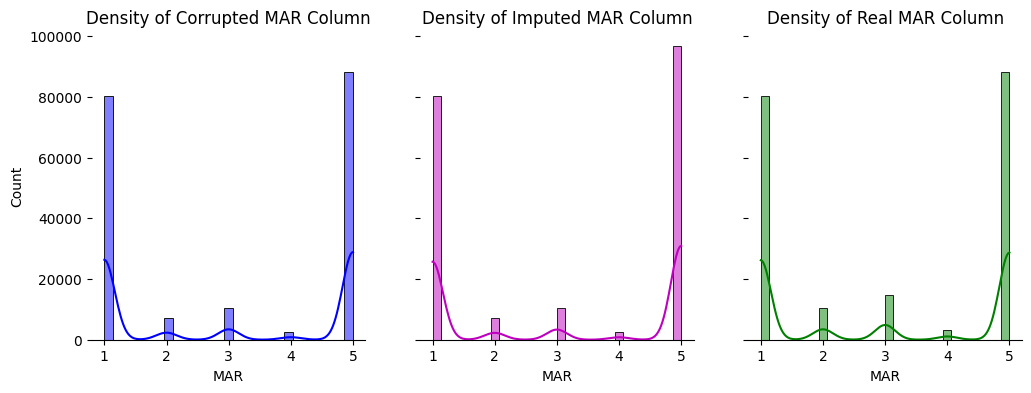





 ###############  Impute MAR column with impute-by-mode-conditional technique  ###############
Impute MAR with value 5.0, where SEX == 2
Impute MAR with value 5.0, where SEX == 1
Number of nulls in MAR column in the corrupted dataframe:  8603
Number of nulls in MAR column in the imputed dataframe:  0


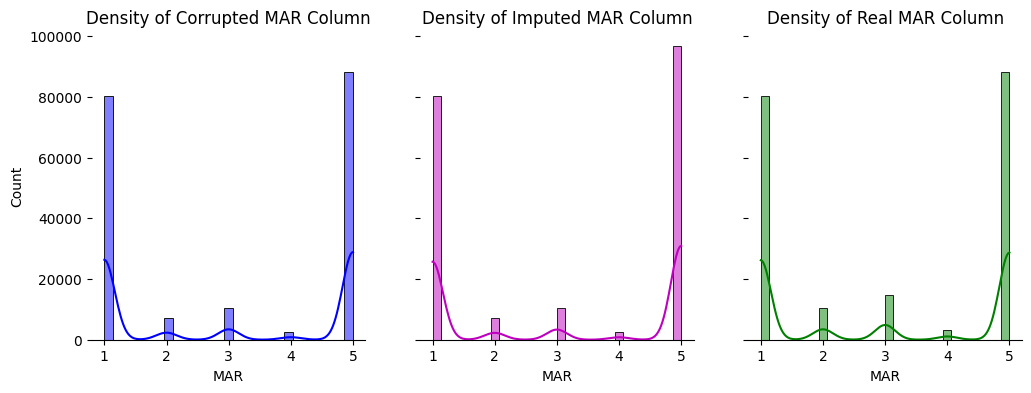

Impute MAR with value 1.0, where RAC1P == 1
Impute MAR with value 5.0, where RAC1P == 2
Impute MAR with value 1.0, where RAC1P == 6
Impute MAR with value 5.0, where RAC1P == 8
Impute MAR with value 5.0, where RAC1P == 9
Impute MAR with value 5.0, where RAC1P == 3
Impute MAR with value 5.0, where RAC1P == 5
Impute MAR with value 5.0, where RAC1P == 7
Impute MAR with value 1.0, where RAC1P == 4
Number of nulls in MAR column in the corrupted dataframe:  8603
Number of nulls in MAR column in the imputed dataframe:  0


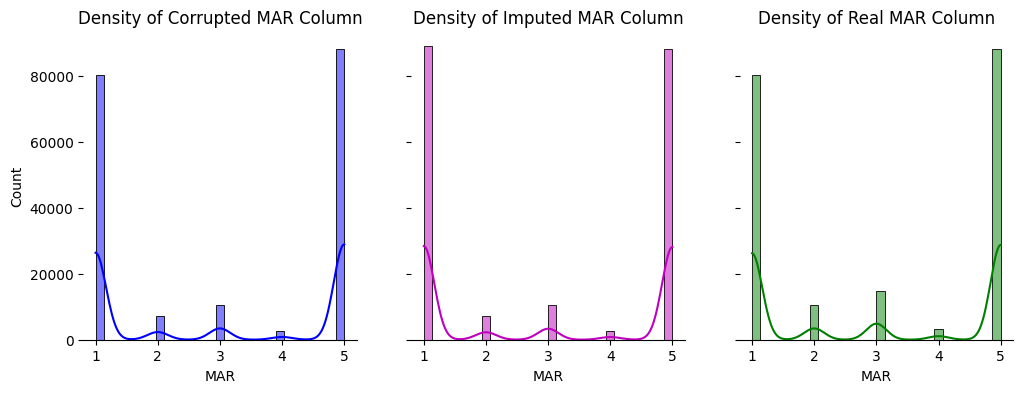

In [64]:
imputed_data_dict = impute_df_with_all_techniques(X_data, corrupted_data, TARGET_COLUMN, COLUMN_TYPE)